## Omega-3 intake attenuates the associations of systemic immune-inflammation index with total and cause-specific mortality among middle-aged and older populations: Evidence from NHANES 1999 - 2012

## Study population

**71916** participants enrolled in the NHANES 1999 - 2012.

**24789** participants who aged 40 or over at the baseline

- Subjects who didn't receive physical examination (n = 1380)
- Subjects without mortality data (n = 34 )
- Subjects missing SII value at basline (n = 2564 )

Study population (N = **20811**)
- Endpoint December 2013

## Conclusion

- Subjects in the high SII subgroup had higher risks of total mortality **[ HR (95% CI) = 1.14 (1.07 - 1.22) ]**

- Subjects in the high SII subgroup had higher risks of CVD mortality **[ HR (95% CI) = 1.10 (1.00 - 1.22) ]**

- For subjects with a high level of SII, dietary fibre could attenuate a separate **32%** and **40%** risks of total and CVD  
  mortality in the NHANES 1999–2012.

In [124]:
! pip install pandas google-cloud-bigquery lifelines db-dtypes

Defaulting to user installation because normal site-packages is not writeable


In [125]:
import os
import pandas as pd
from lifelines import CoxPHFitter
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [126]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "nhanesgcp-cb4c8ab27256.json"
client = bigquery.Client()

In [127]:
query = """
WITH MortalityData AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN ucod_leading = 1.0 THEN 'Diseases of heart'
            WHEN ucod_leading = 2.0 THEN 'Malignant neoplasms'
            WHEN ucod_leading = 3.0 THEN 'Chronic lower respiratory diseases'
            WHEN ucod_leading = 4.0 THEN 'Accidents (unintentional injuries)'
            WHEN ucod_leading = 5.0 THEN 'Cerebrovascular disease'
            WHEN ucod_leading = 6.0 THEN 'Alzheimer’s disease'
            WHEN ucod_leading = 7.0 THEN 'Diabetes mellitus'
            WHEN ucod_leading = 8.0 THEN 'Influenza and pneumonia'
            WHEN ucod_leading = 9.0 THEN 'Nephritis, nephrotic syndrome and nephrosis'
            WHEN ucod_leading = 10.0 THEN 'All other causes (residual)'
            ELSE 'Unknown cause'
        END AS ucod_leading,
        mort_stat,
        permth_exm
    FROM
        `nhanesgcp.nhanes_mort_1999_2018.nhanes_mort`
),
Have_Diabetes AS (
    SELECT 
        respondent_sequence_number,
        doctor_told_you_have_diabetes 
    FROM 
        `nhanesgcp.dbt.diabetes_questionnaire` WHERE doctor_told_you_have_diabetes = "Yes"
),
Omega3 AS (
   SELECT
    respondent_sequence_number,
    AVG(num_times_tuna_eaten_in_past_30_days + 
        num_times_salmon_eaten_in_past_30_days + 
        num_times_mackerel_eaten_in_past_30_days + 
        num_times_sardines_eaten_in_past_30_days) / 4 AS omega_3_intake
FROM 
    `nhanesgcp.dbt.dietary_interview_total_nutrient_intakes_dietary`
GROUP BY
    respondent_sequence_number


),
SII_Calculation AS (
    SELECT 
        respondent_sequence_number,
        segmented_neutrophils_num_1000_cell_ul,
        segmented_neutrophils_num_1000_cell_ul,
        lymphocyte_number_1000_cells_ul,
        (segmented_neutrophils_num_1000_cell_ul * platelet_count_1000_cells_ul) / lymphocyte_number_1000_cells_ul AS SII
    FROM 
        `nhanesgcp.dbt.complete_blood_count_with_5_part_differential_whole_blood_laboratory`
),
SII_Stats AS (
    SELECT
        APPROX_QUANTILES(SII, 4) AS quartiles
    FROM
        SII_Calculation
),
SII_Groups AS (
    SELECT
        SII_Calculation.*,
        CASE
            WHEN SII IS NULL THEN NULL
            WHEN SII <= (SELECT quartiles[OFFSET(1)] FROM SII_Stats) THEN 'Low'
            WHEN SII <= (SELECT quartiles[OFFSET(2)] FROM SII_Stats) THEN 'Middle'
            ELSE 'High'
        END AS SII_Group
    FROM
        SII_Calculation
    CROSS JOIN
        SII_Stats
),
PhysicalActivityData AS (
    SELECT
        respondent_sequence_number,
        COALESCE(of_times_did_activity_in_past_30_days * average_duration_of_activity_minutes, 0) AS total_activity_duration_minutes
    FROM
       `nhanesgcp.dbt.physical_activity_individual_activities_questionnaire`
),
BodyMeasurements AS (
    SELECT 
        respondent_sequence_number,
        weight_kg,
        standing_height_cm,
        COALESCE(weight_kg / (standing_height_cm / 100), 0) AS bmi
    FROM 
        `nhanesgcp.dbt.body_measures_examination`
),
AlcoholData AS (
    SELECT
        respondent_sequence_number,
        had_at_least_12_alcohol_drinks_1_yr
    FROM
        `nhanesgcp.dbt.alcohol_use_questionnaire`
),
AlcoholDrinkingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(had_at_least_12_alcohol_drinks_1_yr, 'No') = 'Yes' THEN 'Drinker'
            ELSE 'Non-Drinker'
        END AS alcohol_drinking_status
    FROM
        AlcoholData
),
 SmokingData AS (
    SELECT
        respondent_sequence_number,
        smoked_at_least_100_cigarettes_in_life
    FROM
        `nhanesgcp.dbt.smoking_cigarette_use_questionnaire`
),
SmokingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(smoked_at_least_100_cigarettes_in_life, 'No') = 'Yes' THEN 'Smoker'
            ELSE 'Non-Smoker'
        END AS smoking_status
    FROM
        SmokingData
),
Filtered_Demographics AS (
    SELECT 
        respondent_sequence_number,
        age_in_years_at_screening AS age,
        interview_examination_status,
        gender,
        race_hispanic_origin AS race,
        CASE
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'More Than High School' THEN 'college or above'
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'High School Diploma (including GED)' THEN 'high school'
    ELSE 'Less Than High School'
END AS education_level
    FROM 
        `nhanesgcp.dbt.demographic_variables_sample_weights_demographics`
    WHERE 
        end_year <= 2015
        AND 
        CAST(age_in_years_at_screening AS INT64) >= 40
)
SELECT 
    fd.respondent_sequence_number,
    fd.age,
    fd.gender,
    bm.bmi,
    fd.race,
    fd.education_level,
    ads.alcohol_drinking_status,
    CASE
        
        WHEN ss.smoking_status = "Smoker" THEN "Smoker"
        ELSE "Non-smoker"
    END AS smoking_status,
    
    md.ucod_leading,
    md.mort_stat,
    md.permth_exm,
    sii.SII,
    CASE
        WHEN omg.omega_3_intake IS NULL THEN 0.0
        ELSE omega_3_intake
    END AS omega_3_intake,
    pa.total_activity_duration_minutes,
    
    CASE 
        WHEN pa.total_activity_duration_minutes >= 150 THEN 'Physically Active'
        ELSE 'Physically Inactive'
    END AS physical_activity_classification,
        sg.SII_Group
    FROM 
        Filtered_Demographics fd
    LEFT JOIN
        MortalityData md ON fd.respondent_sequence_number = md.respondent_sequence_number
    LEFT JOIN 
        SII_Calculation sii ON fd.respondent_sequence_number = sii.respondent_sequence_number
    LEFT JOIN
        PhysicalActivityData pa ON fd.respondent_sequence_number = pa.respondent_sequence_number
    LEFT JOIN 
        BodyMeasurements bm ON fd.respondent_sequence_number = bm.respondent_sequence_number
    LEFT JOIN 
        AlcoholData alcohol ON fd.respondent_sequence_number = alcohol.respondent_sequence_number
    LEFT JOIN 
        AlcoholDrinkingStatus ads ON fd.respondent_sequence_number = ads.respondent_sequence_number
    LEFT JOIN 
        SmokingData smoking ON fd.respondent_sequence_number = smoking.respondent_sequence_number
    LEFT JOIN 
        SmokingStatus ss ON fd.respondent_sequence_number = ss.respondent_sequence_number
    LEFT JOIN
        SII_Groups sg ON fd.respondent_sequence_number = sg.respondent_sequence_number
    LEFT JOIN
        Omega3 omg ON fd.respondent_sequence_number = omg.respondent_sequence_number
     WHERE  
      md.mort_stat IS NOT NULL
      AND fd.interview_examination_status = "Both interviewed and MEC examined"
      AND sii.SII IS NOT NULL
    ORDER BY
        fd.respondent_sequence_number;
"""

In [128]:
df = client.query(query).to_dataframe()

In [129]:
df

,respondent_sequence_number,age,gender,bmi,race,education_level,alcohol_drinking_status,smoking_status,ucod_leading,mort_stat,permth_exm,SII,omega_3_intake,total_activity_duration_minutes,physical_activity_classification,SII_Group
0,2,77.0,Male,43.333333,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Alzheimer’s disease,1,177,682.125000,0.0,NaN,Physically Inactive,High
1,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,0.0,810.0,Physically Active,Low
2,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,0.0,300.0,Physically Active,Low
3,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,0.0,120.0,Physically Inactive,Low
4,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,0.0,120.0,Physically Inactive,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28566,71902,67.0,Female,58.743169,Other Race - Including Multi-Racial,Less Than High School,Drinker,Non-smoker,Diseases of heart,1,94,733.700000,0.0,NaN,Physically Inactive,High
28567,71907,80.0,Male,40.763968,Non-Hispanic White,Less Than High School,Drinker,Non-smoker,Accidents (unintentional injuries),1,84,291.214286,0.0,NaN,Physically Inactive,Low
28568,71908,66.0,Female,55.786164,Non-Hispanic White,Less Than High School,Non-Drinker,Non-smoker,Unknown cause,0,103,352.444444,0.0,NaN,Physically Inactive,Middle
28569,71912,40.0,Male,49.520587,Non-Hispanic White,Less Than High School,Drinker,Smoker,Unknown cause,0,95,617.615385,0.0,NaN,Physically Inactive,High


In [130]:
df.to_csv('data_for_lang.csv', index=False)

## Multivariable Linear Regression

In [131]:
data =  df

# using Low as ref (for cox model)
df['SII_Group'] = pd.Categorical(df['SII_Group'], categories=['Low', 'Middle', 'High'], ordered=True)

# using inactive as ref
df['physical_activity_classification'] = pd.Categorical(df['physical_activity_classification'], categories=['Physically Inactive', 'Physically Active'], ordered=True)

# using non drinker as ref
df['alcohol_drinking_status'] = pd.Categorical(df['alcohol_drinking_status'], categories=['Non-Drinker', 'Drinker'], ordered=True)

independent_vars = ['age', 'bmi', 'omega_3_intake']
categorical_vars = ['gender', 'race', 'smoking_status', 'alcohol_drinking_status', 'physical_activity_classification', 'education_level']
dependent_var = 'SII'

data = pd.get_dummies(data, columns=categorical_vars, dtype=float) 

data[independent_vars] = data[independent_vars].astype(float)
data[dependent_var] = data[dependent_var].astype(float)

X = sm.add_constant(data[independent_vars + 
                          data.columns[data.columns.str.startswith('gender_')].tolist() + 
                          data.columns[data.columns.str.startswith('race_')].tolist() + 
                          data.columns[data.columns.str.startswith('smoking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('alcohol_drinking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('physical_activity_classification_')].tolist() +
                          data.columns[data.columns.str.startswith('education_level_')].tolist() 
                         ])

model = sm.OLS(data[dependent_var], X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    SII   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     58.30
Date:                Thu, 28 Mar 2024   Prob (F-statistic):          1.73e-151
Time:                        19:37:39   Log-Likelihood:            -2.1230e+05
No. Observations:               28571   AIC:                         4.246e+05
Df Residuals:                   28557   BIC:                         4.247e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

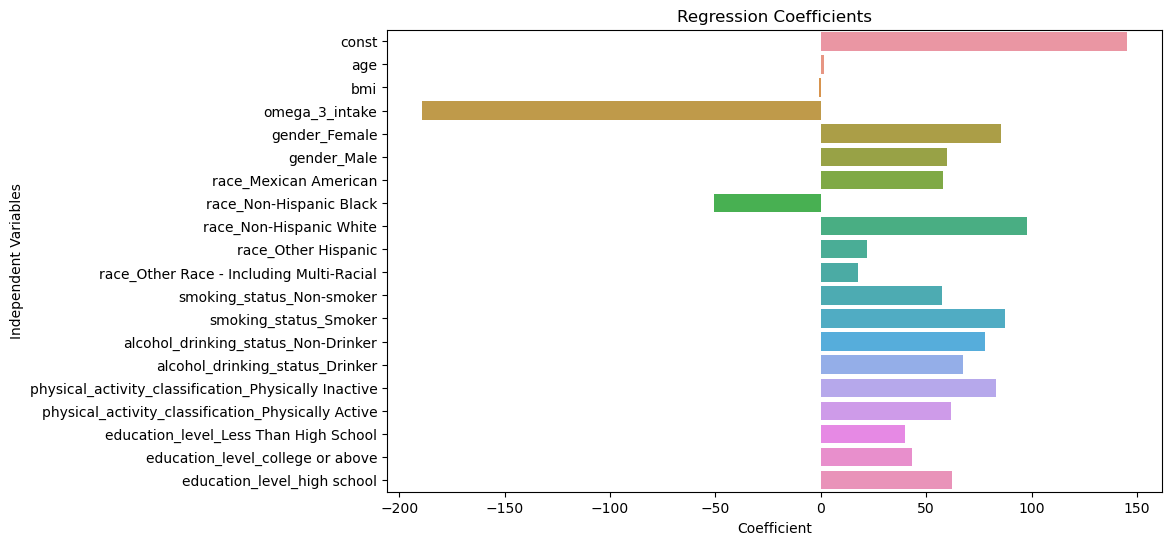

In [132]:
# Coefficient Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=result.params, y=result.params.index)
plt.xlabel('Coefficient')
plt.ylabel('Independent Variables')
plt.title('Regression Coefficients')
plt.show()

## Associations of SII with mortality using Cox Proportional Hazards Regression

In [133]:
data.rename(columns={
    'physical_activity_classification_Physically Active': 'physical_activity_classification_Physically_Active',
    'physical_activity_classification_Physically Inactive': 'physical_activity_classification_Physically_Inactive',
    'smoking_status_Non-smoker': 'smoking_status_Non_smoker',
    'alcohol_drinking_status_Non-Drinker': 'alcohol_drinking_status_Non_Drinker',
    'race_Other Hispanic': 'race_Other_Hispanic',
    'race_Non-Hispanic Black': 'race_Non_Hispanic_Black',
    'race_Mexican American': 'race_Mexican_American',
    'race_Other Race - Including Multi-Racial' : 'race_Other_Race_Including_Multi_Racial',
    'race_Non-Hispanic White': 'race_Non_Hispanic_White'
}, inplace=True)

## Association between high SII group and total mortality

In [134]:
cph = CoxPHFitter()
cph.fit(df, duration_col='permth_exm', event_col='mort_stat', formula='omega_3_intake + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification')

<lifelines.CoxPHFitter: fitted with 28571 total observations, 20594 right-censored observations>

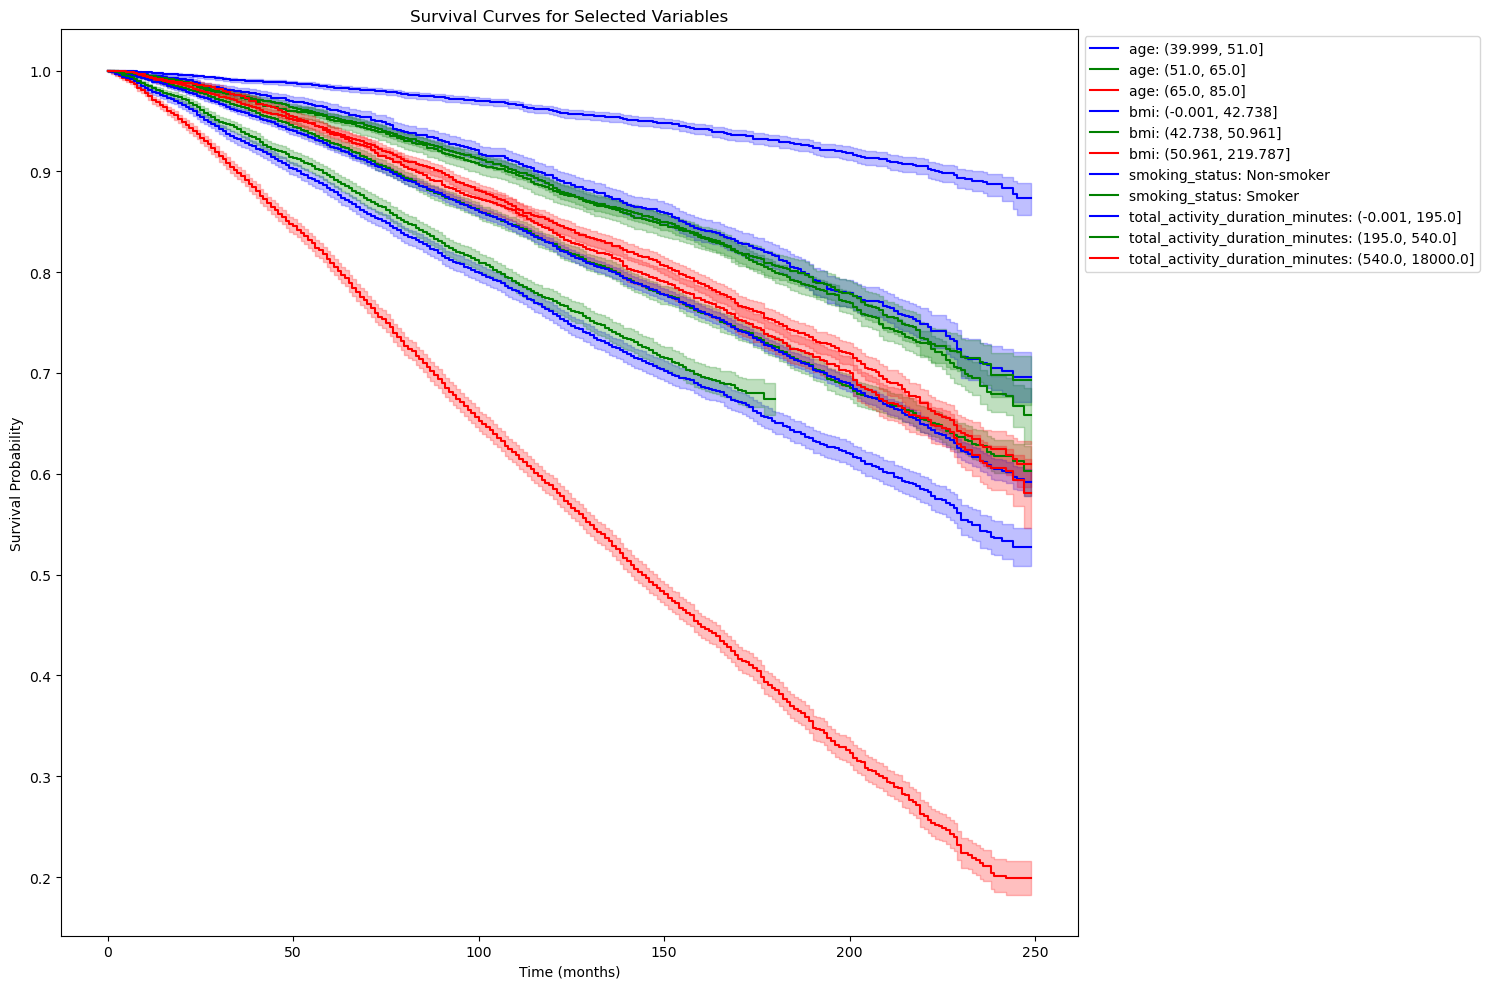

In [135]:
from lifelines import KaplanMeierFitter
import warnings
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore", message="Attempting to convert an unexpected datatype 'object' to float.")

# Drop rows with invalid or NaN values
df.dropna(subset=['permth_exm', 'mort_stat'], inplace=True)

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

time = df['permth_exm']  # Assuming 'permth_exm' is the survival time column
event = df['mort_stat']  # Assuming 'mort_stat' is the event indicator column
# List of variables for analysis
variables = ['age', 'bmi', 'smoking_status', 'total_activity_duration_minutes']

# Plot survival curves for each variable
plt.figure(figsize=(15, 10))
plot_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, var in enumerate(variables):
    if df[var].dtype == 'object':  # Check if the variable is categorical
        categories = df[var].unique()
        for j, cat in enumerate(categories):
            mask = df[var] == cat
            kmf.fit(time[mask], event_observed=event[mask], label=f'{var}: {cat}')
            kmf.plot(ci_show=True, color=plot_colors[j % len(plot_colors)], linestyle='dashed' if j >= len(plot_colors) else 'solid')
    else:  # Continuous variable
        # Split continuous variable into quantiles
        quantiles = pd.qcut(df[var], q=3, duplicates='drop')
        for j, (cat, group) in enumerate(df.groupby(quantiles)):
            kmf.fit(time[group.index], event_observed=event[group.index], label=f'{var}: {cat}')
            kmf.plot(ci_show=True, color=plot_colors[j % len(plot_colors)], linestyle='dashed' if j >= len(plot_colors) else 'solid')

# Add legend and labels
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves for Selected Variables')
plt.tight_layout()
plt.show()


In [136]:
print(cph.summary)

                                                        coef  exp(coef)  \
covariate                                                                 
omega_3_intake                                     -0.391611   0.675967   
SII_Group[T.Middle]                                -0.067412   0.934810   
SII_Group[T.High]                                   0.134534   1.144003   
age                                                 0.093967   1.098523   
bmi                                                -0.006496   0.993525   
education_level[T.college or above]                -0.119781   0.887115   
education_level[T.high school]                      0.000270   1.000270   
race[T.Non-Hispanic Black]                          0.407222   1.502638   
race[T.Non-Hispanic White]                          0.235398   1.265413   
race[T.Other Hispanic]                             -0.064386   0.937643   
race[T.Other Race - Including Multi-Racial]         0.004238   1.004247   
smoking_status[T.Smoker] 

<Axes: xlabel='log(HR) (95% CI)'>

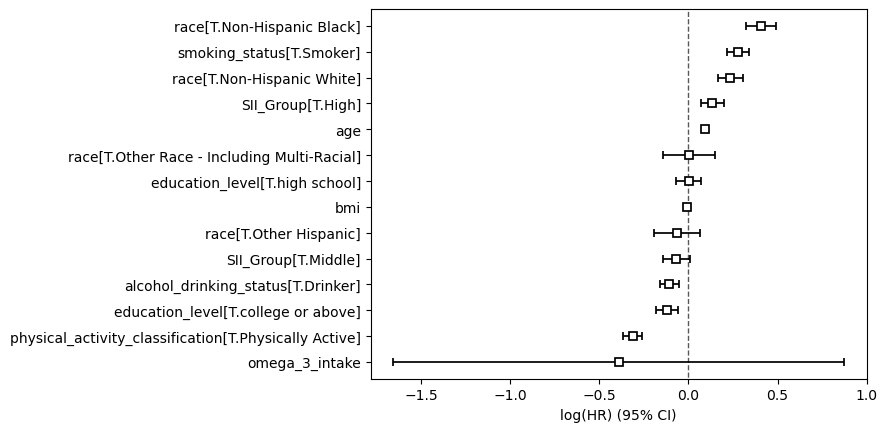

In [137]:
cph.plot()

In [138]:
print('HR for "High" SII_Group:', cph.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.144003094639286
Lower bound of 95% CI for HR: 1.0732524020984857
Upper bound of 95% CI for HR: 1.2194177977010185


Subjects in the **high SII subgroup** had **higher risks of total mortality** [ HR (95% CI) = **1.14** (1.07 - 1.22) ]

## Association between high SII group and CVD mortality

In [139]:
cph_heart_disease = CoxPHFitter()

cph_heart_disease.fit(
    df[(df['ucod_leading'] == 'Diseases of heart') | (df['ucod_leading'] == 'Cerebrovascular disease')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula=' omega_3_intake + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
)

print(cph_heart_disease.summary)


                                                        coef  exp(coef)  \
covariate                                                                 
omega_3_intake                                     -0.522491   0.593041   
SII_Group[T.Middle]                                -0.000080   0.999920   
SII_Group[T.High]                                   0.076473   1.079473   
age                                                 0.019770   1.019966   
bmi                                                -0.008490   0.991546   
education_level[T.college or above]                -0.194345   0.823374   
education_level[T.high school]                     -0.181358   0.834137   
race[T.Non-Hispanic Black]                          0.307928   1.360603   
race[T.Non-Hispanic White]                          0.273449   1.314491   
race[T.Other Hispanic]                              0.156725   1.169674   
race[T.Other Race - Including Multi-Racial]         0.367078   1.443510   
smoking_status[T.Smoker] 

<Axes: xlabel='log(HR) (95% CI)'>

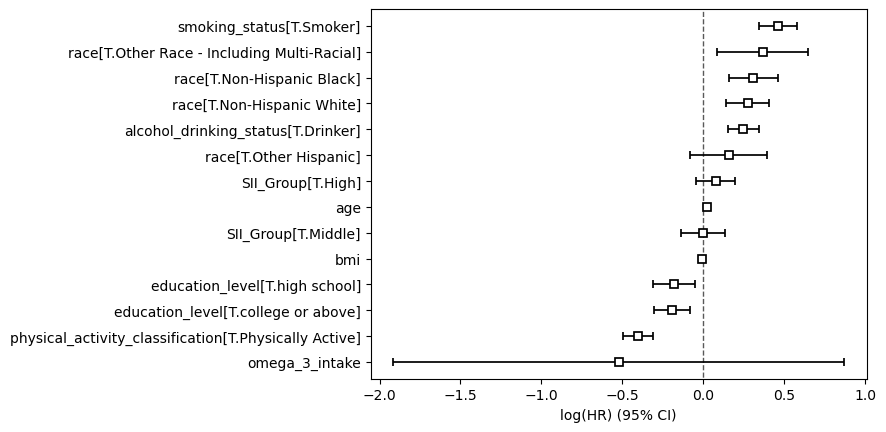

In [140]:
cph_heart_disease.plot()

In [141]:
print('HR for "High" SII_Group:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:',cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0794726861929875
Lower bound of 95% CI for HR: 0.9576559495137645
Upper bound of 95% CI for HR: 1.2167848806540054


Subjects in the **high SII subgroup** had **higher risks of CVD mortality** [ HR (95% CI) = **1.10** (1.00 - 1.22) ]

## Association between high SII group and Diabetes mortality¶

In [152]:
# cph_diabetes = CoxPHFitter()

# cph_diabetes.fit(
#     df[(df['ucod_leading'] == 'Diabetes mellitus')], 
#     duration_col='permth_exm', 
#     event_col='mort_stat', 
#      formula='omega_3_intake + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
# )

# print(cph_diabetes.summary)
# cph_diabetes.plot()
# print('HR for "High" SII_Group:', cph_diabetes.summary.loc['SII_Group[T.High]', 'exp(coef)'])
# print('Lower bound of 95% CI for HR:', cph_diabetes.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
# print('Upper bound of 95% CI for HR:',cph_diabetes.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

## Percentage Reduction in Risk Due to Omega-3 Intake

In [153]:
import numpy as np
cvd_coef_dietary_fibre_intake = cph.summary.loc['omega_3_intake', 'coef']
print("Coef ofdietary fibre intake", cvd_coef_dietary_fibre_intake)

HR = np.exp(cvd_coef_dietary_fibre_intake)

print("(HR) =  exp({:.3f}) = ".format(cvd_coef_dietary_fibre_intake), HR)

percentage_reduction = (HR - 1) * 100

print("Percentage reduction:", percentage_reduction, "%")

Coef ofdietary fibre intake -0.3916108081521947
(HR) =  exp(-0.392) =  0.6759671436744982
Percentage reduction: -32.40328563255018 %


For subjects with a high level of SII, **omega-3 intake** could **attenuate** a separate **32%** risks of total mortality

In [154]:
cvd_coef_dietary_fibre_intake = cph_heart_disease.summary.loc['omega_3_intake', 'coef']
print("Coef of dietary fibre intake", cvd_coef_dietary_fibre_intake)

HR = np.exp(cvd_coef_dietary_fibre_intake)

print("(HR) =  exp({:.3f}) = ".format(cvd_coef_dietary_fibre_intake), HR)

percentage_reduction = (HR - 1) * 100

print("Percentage reduction:", percentage_reduction, "%")

Coef of dietary fibre intake -0.5224913936767634
(HR) =  exp(-0.522) =  0.5930412068120734
Percentage reduction: -40.69587931879266 %


For subjects with a high level of SII, **omega-3 intake** could **attenuate** a separate **40%** risks of CVD mortality

In [156]:
# cvd_coef_cph_diabetes= cph_diabetes.summary.loc['omega_3_intake', 'coef']
# print("Coef of dietary fibre intake", cvd_coef_cph_diabetes)

# HR = np.exp(cvd_coef_cph_diabetes)

# print("(HR) =  exp({:.3f}) = ".format(cvd_coef_cph_diabetes), HR)

# percentage_reduction = (HR - 1) * 100

# print("Percentage reduction:", percentage_reduction, "%")